# Introduction to machine learning with `sklearn`

## What is machine learning?

Machine learning is the development and use of algorithms that make use data to predict future observations.   It is very related to statistics and statistical inference, but the emphasis is 1) more on computational methods, rather than analytical procedures, and 2) in prediction, rather than description or causal inference.




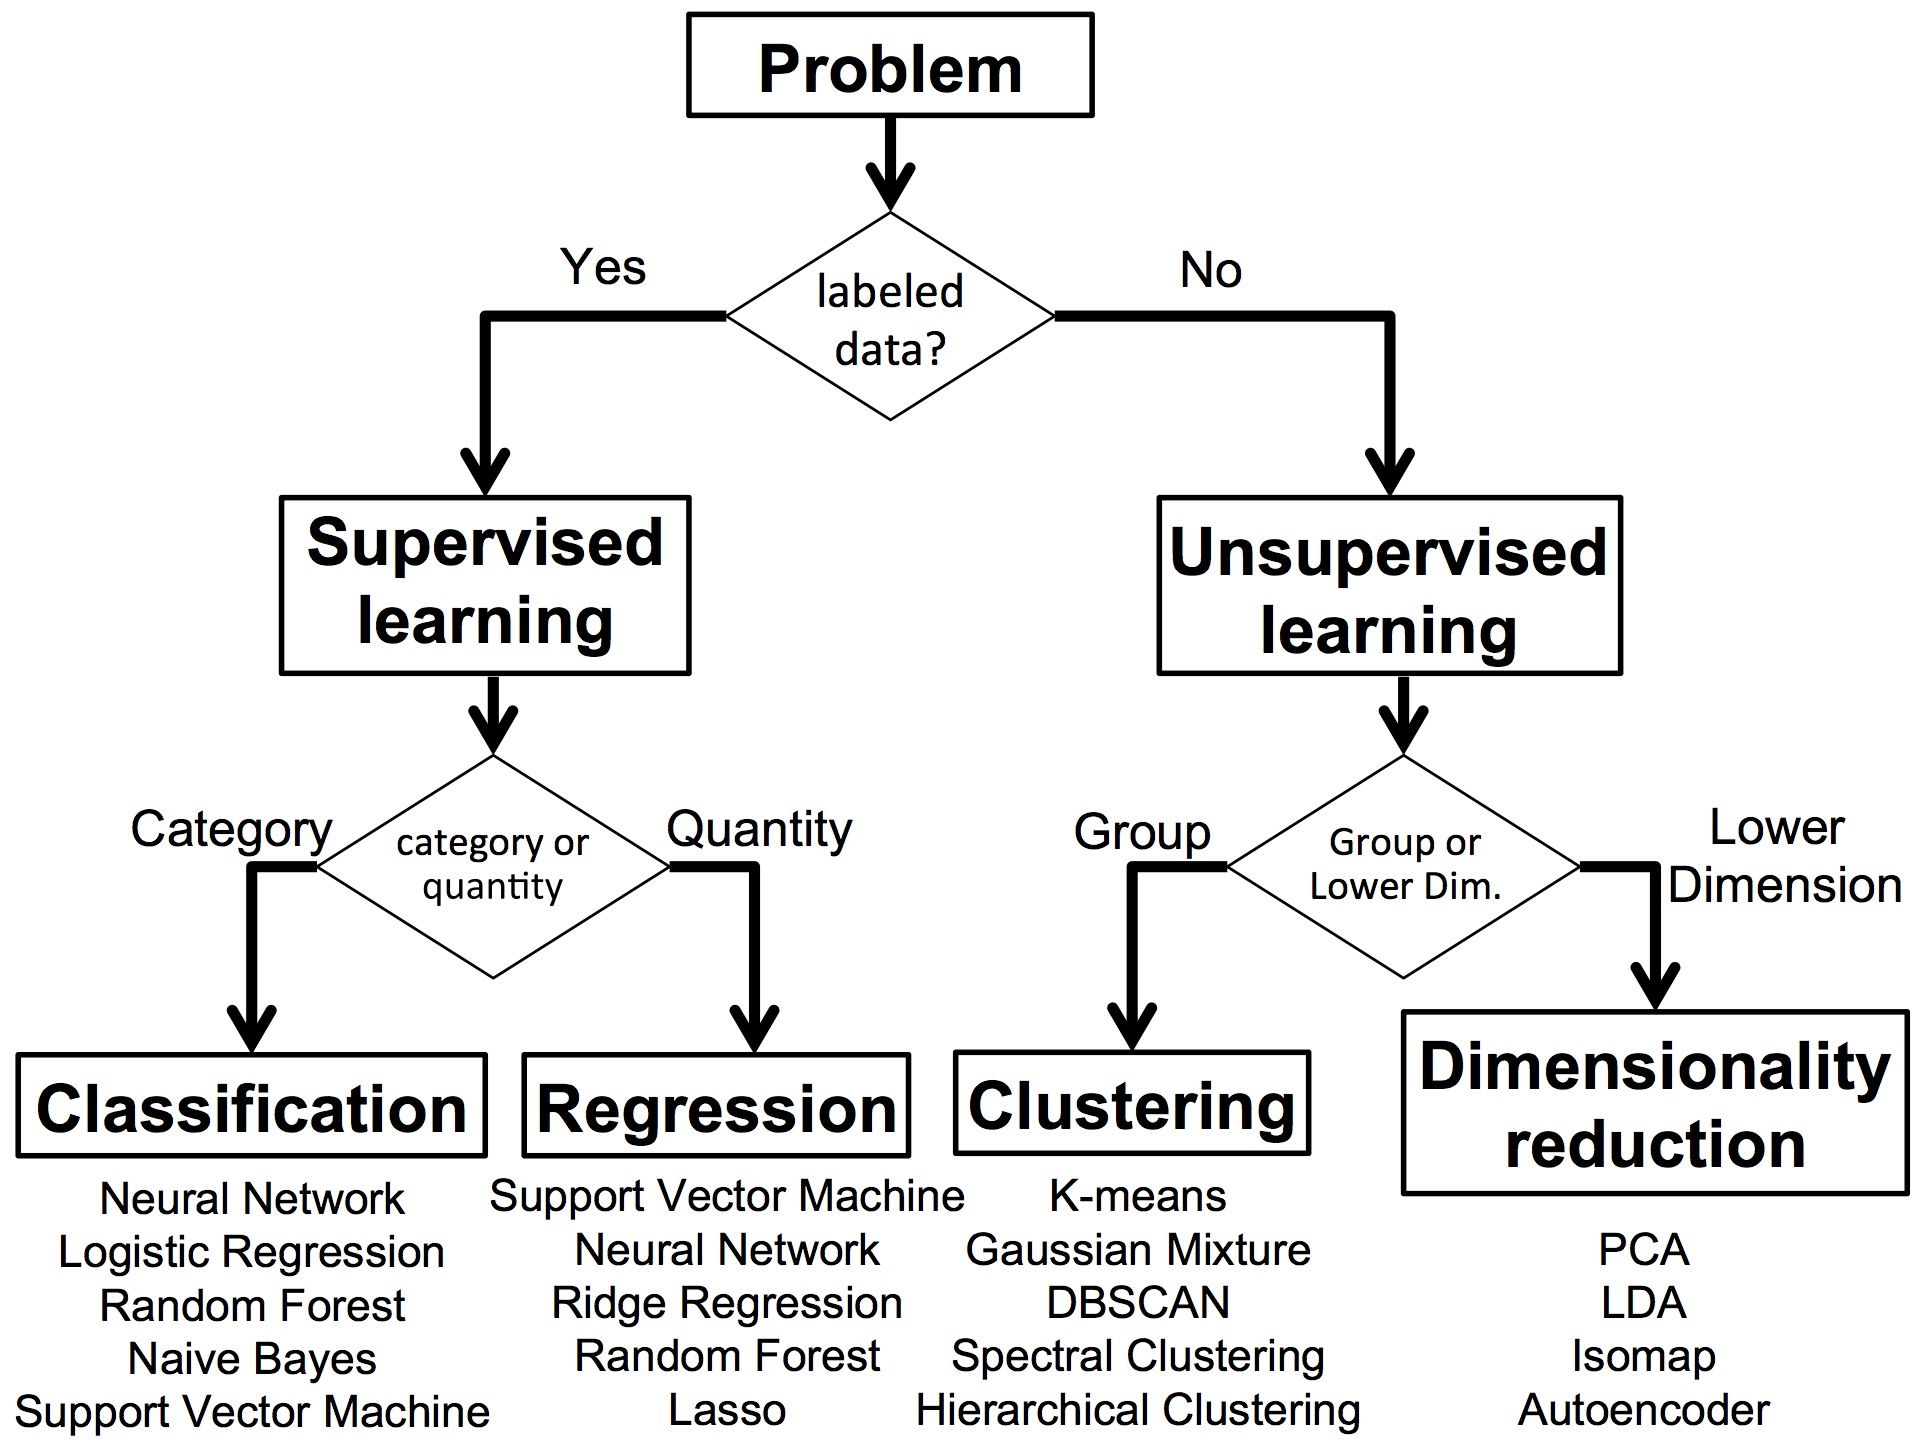

Machine learning tasks involve:

* data clean-up
* feature selection / dimensionality reduction
* model selection
  * model tuning
  * Performance evaluation



## Bias Variance tradeoff


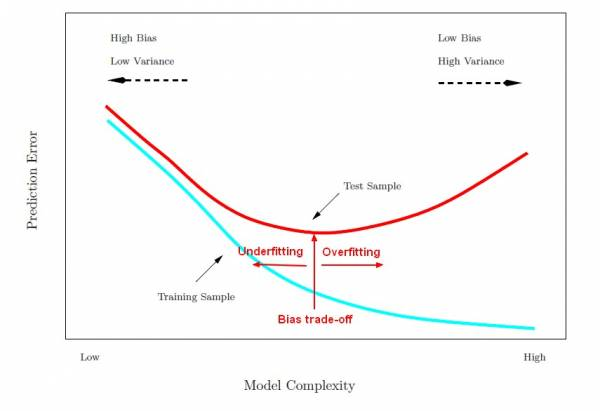

## Performance metrics (for classifiers)

* Confusion matrix
  * Accuracy: crude measure of performance
  * Sensitivity/Recall: true positive rate TP/(TP+FN) - how well do you predict positives
  * Specificity: True negative rate - TN/(TN+FP)
  * Precision/PPV: TP/(TP+FP)

  * F1: 2 (precision x recall) / (precision + recall) - harmonic mean of precision and recall



* ROC curve



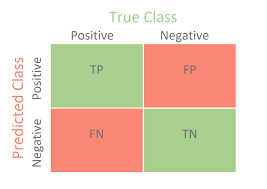

## An Example

In [ ]:
import sklearn as skl
import pandas as pd # python library commonly used to process data tables
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_wt = pd.read_csv("/content/drive/MyDrive/COB2022/data/Measurements/wt.csv")
data_sle1 = pd.read_csv("/content/drive/MyDrive/COB2022/data/Measurements/sle1.csv")

data_wt['genotype'] = 'wt'
data_sle1['genotype'] = 'sle1'
data = data_wt.append(data_sle1).reset_index(drop=True)

In [ ]:
data.columns

Index(['Cell ID ', 'Area', 'Perimeter', 'Length', 'Width', 'Eccentricity',
       'Irregularity', 'Cell Cycle Phase', 'genotype', 'Neighbours',
       'Baseline', 'Cell Median', 'Membrane Median', 'Cytoplasm Median'],
      dtype='object')

###  Exploring - take a look at our data

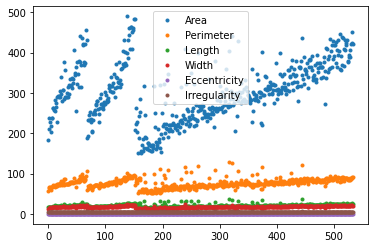

In [ ]:
data[[ 'Area', 'Perimeter', 'Length', 'Width', 'Eccentricity',
       'Irregularity']].plot(ls='',marker='.')

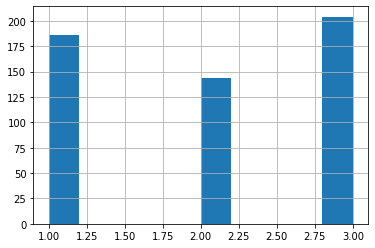

In [ ]:
data['Cell Cycle Phase'].hist()

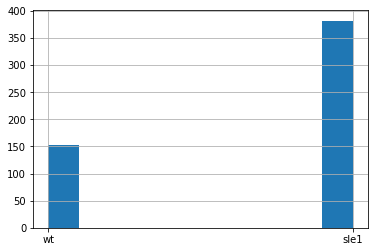

In [ ]:
data['genotype'].hist()

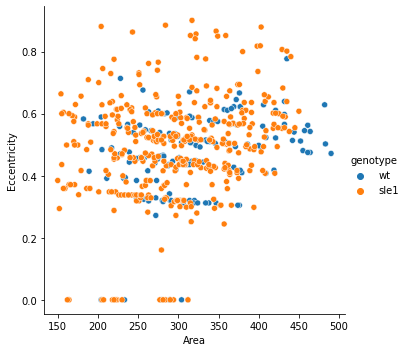

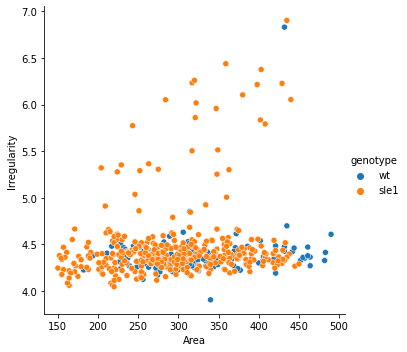

In [ ]:
sns.relplot(data=data,x='Area',y='Eccentricity',hue='genotype')
sns.relplot(data=data,x='Area',y='Irregularity',hue='genotype')

## Basic classifier for genotype




In [ ]:

from sklearn.preprocessing import StandardScaler

rows, columns = data.shape

## shuffle data
data = data.sample(frac=1,replace=False,random_state=0).reset_index(drop=True)

## standardize variables
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']

for col in cols:
  scaler = StandardScaler()
  data[col+"_scaled"] = scaler.fit_transform(data[[col]])

## split into train, test
train = data.loc[0:int(rows*0.8), :].copy() #separates 80% of data as training data
test = data.loc[int(rows*0.8):, :].copy() #separates 20% of data as validation data

In [ ]:
from sklearn.linear_model import LogisticRegression

x_cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']
y_col = 'genotype'

# fit on training set
clf = LogisticRegression().fit(train[x_cols],train[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])
# accuracy on test set
sum(preds==test[y_col])/test.shape[0]



0.7289719626168224

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
conf_mat

array([[0.98701299, 0.01298701],
       [0.93333333, 0.06666667]])

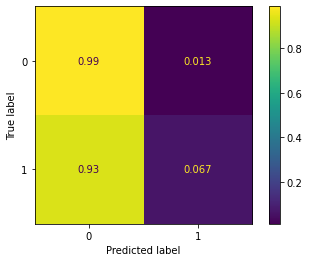

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

Accuracy is not a good metric! 

Could this be because of the class inbalance? How to balance a dataset?


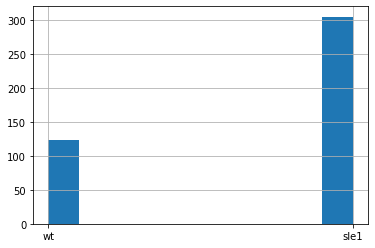

In [ ]:
train['genotype'].hist()

In [ ]:
train[train['genotype']=='wt'].shape,train[train['genotype']=='sle1'].shape

((123, 20), (305, 20))

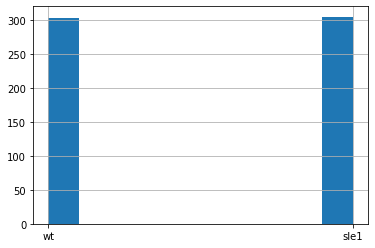

In [ ]:
train_oversampled = train.append( train[train['genotype']=='wt'].sample(n=180,replace=True) ).reset_index(drop=True)

train_oversampled['genotype'].hist()

In [ ]:
from sklearn.linear_model import LogisticRegression

x_cols = [col+'_scaled' for col in cols]
y_col = 'genotype'

# fit on training set
clf = LogisticRegression().fit(train_oversampled[x_cols],train_oversampled[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])

array([[0.57142857, 0.42857143],
       [0.3       , 0.7       ]])

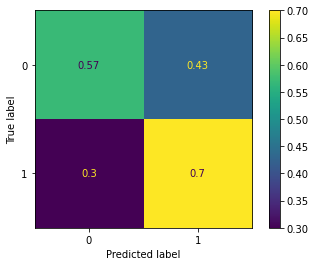

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
conf_mat

**Exercise** Can you implement undersampling? reducing the number of examples of the majority class?

In [ ]:
from sklearn.linear_model import LogisticRegression

x_cols = [col+'_scaled' for col in cols]
y_col = 'genotype'

# fit on training set
clf = LogisticRegression(class_weight='balanced').fit(train[x_cols],train[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])

array([[0.58441558, 0.41558442],
       [0.3       , 0.7       ]])

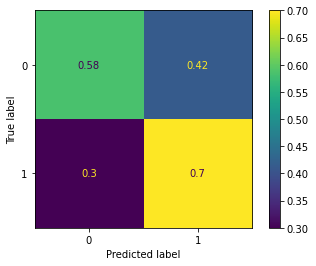

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
conf_mat

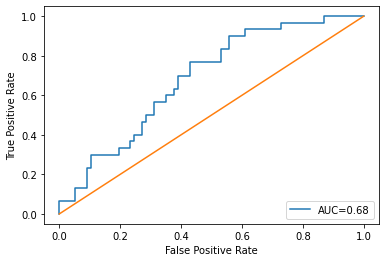

In [ ]:
from sklearn.metrics import roc_curve,RocCurveDisplay,roc_auc_score,f1_score

probs = clf.predict_proba(test[x_cols])
fpr, tpr, thresholds = roc_curve(test[y_col], probs[:,1],pos_label='wt')
AUC = roc_auc_score(test[y_col], probs[:,1])

# preds = clf.predict(test[x_cols])
# f1 = f1_score(test[y_col], preds,pos_label='wt')

RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label = 'AUC={auc:.2f}'.format(auc=AUC))
plt.plot([0,1],[0,1])


**Exercise**: fit a logistic regression model and calculate the f1 metric on the test set.

**Very Crappy!**

Let's see if any of the available classifiers can do better.

Thankfully, all classifiers in `sklearn` obey the same API, ie, they all have the methods:

* `fit()`
* `predict()`
* `predict_proba()`

but wait, as we tweak our model or testing different models, if we keep testing against the test set, we incur in **data leakage**. that is, we are inplicily fitting against the test set. This is not good


We have a few options:
* we can make many train/test splits (**BAD**)
* we can bootstrap our training set, always testing against the same test set (Also **BAD**)
* OR you can do cross-validation (better)

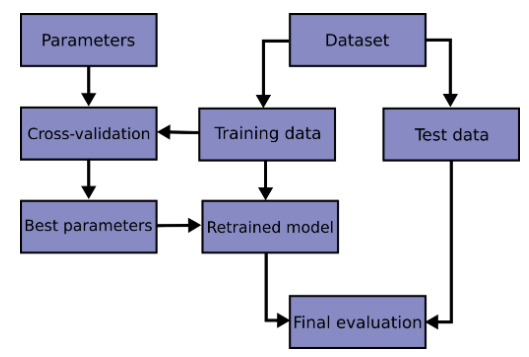

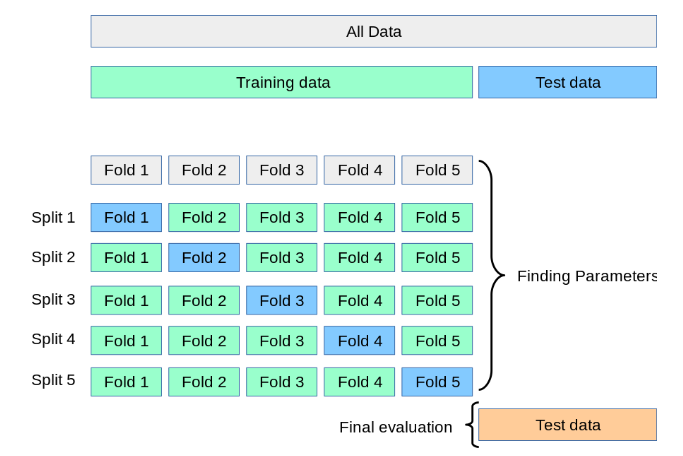

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
import numpy as np

train_oversampled['target'] = train_oversampled['genotype'].apply(lambda x: 1 if x=='wt' else 0)
test['target'] = test['genotype'].apply(lambda x: 1 if x=='wt' else 0)

clf = LogisticRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
scores = cross_val_score(clf, train_oversampled[x_cols], train_oversampled['target'], cv=cv,scoring='roc_auc')

print(scores)
print("cross-validated mean and standard deviation:", np.mean(scores),np.std(scores))
probs = clf.fit(train_oversampled[x_cols],train_oversampled['target']).predict_proba(train_oversampled[x_cols])
print("train score",roc_auc_score(train_oversampled['target'],probs[:,1]) )


[0.58191633 0.64040404 0.58183284 0.65301724 0.59432948]
cross-validated mean and standard deviation: 0.6102999866049129 0.030338376199691392
train score 0.6255694421901206


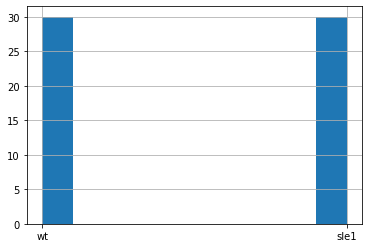

In [ ]:

test_undersample = test[test['genotype']=='wt'].append( test[test['genotype']=='sle1'].sample(n=30,replace=False) ).reset_index(drop=True)
test_undersample['genotype'].hist();

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025,probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

results = []

for name,clf in zip(names,classifiers):
  print(name)

  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
  scores = cross_val_score(clf, train_oversampled[x_cols], train_oversampled['target'], cv=cv,scoring='roc_auc')


  # clf.fit(train_oversampled[x_cols],train_oversampled[y_col])

  # probs = clf.predict_proba(test[x_cols])
  # test_auc = roc_auc_score(test[y_col], probs[:,1])
  # probs = clf.predict_proba(train_oversampled[x_cols])
  # train_auc = roc_auc_score(train_oversampled[y_col], probs[:,1])

  results.append({"model":name,"train_auc_mean":np.mean(scores),"train_auc_std":np.std(scores)})

results_df= pd.DataFrame(results)

Nearest Neighbors
Linear SVM
RBF SVM
Gaussian Process
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA


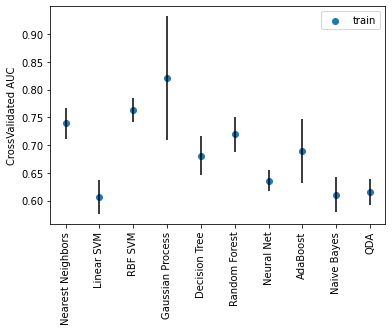

In [ ]:
plt.scatter(results_df['model'],results_df['train_auc_mean'],label='train');
plt.vlines(results_df['model'],results_df['train_auc_mean']-results_df['train_auc_std'],results_df['train_auc_mean']+results_df['train_auc_std'])
# plt.scatter(results_df['model'],results_df['test_auc'],label='test');
plt.xticks(rotation=90);
plt.ylabel("CrossValidated AUC")
plt.legend();

**Exercise** repeat the same procedure, but for the undersampled dataset

Lets pick one of the more promising classifiers and try to tweak it.
The Support Vector Machine with a radial basis function seems promissing (yeah, we are skipping GAussian processes).

SVCs have at least two parameters: gamma and C. 


In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals = [.1,.2,.5,1,1.5,2,5,10]

svc = SVC(kernel='rbf')
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
parameters = { 'C':C_vals}
clf = GridSearchCV(svc, parameters,cv=cv,scoring='roc_auc')

clf.fit(train_oversampled[x_cols],train_oversampled['target'])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.2, train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.5, 1, 1.5, 2, 5, 10]},
             scoring='roc_auc')

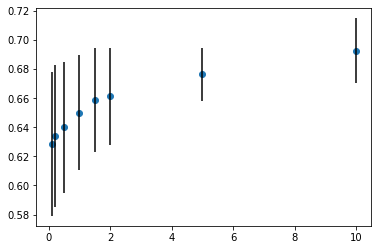

In [ ]:
res = clf.cv_results_

plt.scatter(C_vals,res['mean_test_score'])
plt.vlines(C_vals,res['mean_test_score']-res['std_test_score'],res['mean_test_score']+res['std_test_score'])

In [ ]:
from sklearn.model_selection import GridSearchCV

g_vals = [.1,.2,.5,1,1.5,2]

svc = SVC(kernel='rbf',C=2)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
parameters = { 'gamma':g_vals}
clf = GridSearchCV(svc, parameters,cv=cv,scoring='roc_auc')

clf.fit(train_oversampled[x_cols],train_oversampled['target'])

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.2, train_size=None),
             estimator=SVC(C=2),
             param_grid={'gamma': [0.1, 0.2, 0.5, 1, 1.5, 2]},
             scoring='roc_auc')

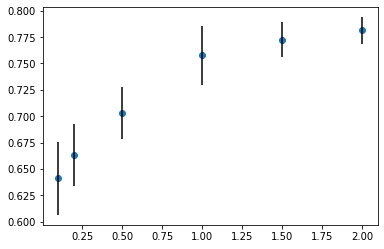

In [ ]:
res = clf.cv_results_
plt.scatter(g_vals,res['mean_test_score'])
plt.vlines(g_vals,res['mean_test_score']-res['std_test_score'],res['mean_test_score']+res['std_test_score'])

In [ ]:
from sklearn.model_selection import ShuffleSplit,cross_val_score
import numpy as np

clf = SVC(C=2,gamma=2,probability=True)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, train_oversampled[x_cols], train_oversampled['target'], cv=cv,scoring='roc_auc')

print(scores)
print("cross-validated mean and standard deviation:", np.mean(scores),np.std(scores))

probs = clf.fit(train_oversampled[x_cols],train_oversampled['target']).predict_proba(train_oversampled[x_cols])
print("train score",roc_auc_score(train_oversampled['target'],probs[:,1]) )

probs = clf.fit(train_oversampled[x_cols],train_oversampled['target']).predict_proba(test_undersample[x_cols])
print("test score",roc_auc_score(test_undersample['target'],probs[:,1]) )

[0.7483871  0.86290323 0.76109307 0.79310345 0.71524784]
cross-validated mean and standard deviation: 0.7761469378554334 0.05004019161109948
train score 0.9137802304820646
test score 0.6255555555555555


array([[0.7, 0.3],
       [0.4, 0.6]])

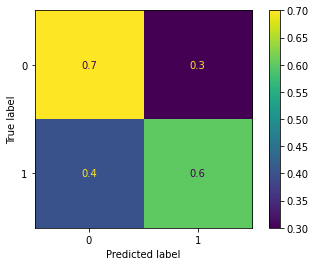

In [ ]:
preds = clf.fit(train_oversampled[x_cols],train_oversampled['target']).predict(test_undersample[x_cols])
conf_mat = confusion_matrix(test_undersample['target'],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()
conf_mat

In [ ]:
res

{'mean_fit_time': array([0.01925616, 0.01504583, 0.01591101, 0.01629467, 0.01624103,
        0.01677265]),
 'std_fit_time': array([0.00656759, 0.00070172, 0.00080957, 0.00122049, 0.00106864,
        0.00306718]),
 'mean_score_time': array([0.00592313, 0.0060451 , 0.00743914, 0.00564909, 0.00560317,
        0.00567203]),
 'std_score_time': array([0.00015536, 0.00052827, 0.00141848, 0.00014886, 0.00021362,
        0.00036631]),
 'param_gamma': masked_array(data=[0.1, 0.2, 0.5, 1, 1.5, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0.1},
  {'gamma': 0.2},
  {'gamma': 0.5},
  {'gamma': 1},
  {'gamma': 1.5},
  {'gamma': 2}],
 'split0_test_score': array([0.69824561, 0.73036437, 0.80512821, 0.77408907, 0.77813765,
        0.77192982]),
 'split1_test_score': array([0.65772006, 0.71544012, 0.76334776, 0.78874459, 0.76190476,
        0.77200577]),
 'split2_test_score': array([0.65197528, 0.70249933, 0.7

You can't always win...

## Automatic Cell Cycle Classification based on morphological features

### Loading data using pandas

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/COB2022/data/Measurements/wt.csv") # imports a csv and creates a dataframe object
data.head() # .head can be used to visualize the first five rows of your dataframe

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Irregularity,Cell Cycle Phase
0,1,182,57,16.000000,13.000000,0.582961,4.225121,1
1,2,211,64,16.552945,15.231546,0.391516,4.405942,1
2,3,237,67,18.027756,14.866069,0.565685,4.352118,1
3,4,227,66,17.000000,16.000000,0.337915,4.380574,1
4,5,204,60,15.000000,15.000000,0.000000,4.200840,1


### Randomize data 

### Normalize data to mean 0 and std 1

In [ ]:
mean_values = {} # we store these values to normalize new samples
std_values = {}
for col_name in data.columns:
  if col_name != "Cell ID " and col_name != "Cell Cycle Phase": #we do this to avoid normalization of these parameters
    mean_values[col_name] = data[col_name].mean()
    std_values[col_name] = data[col_name].std()

print(mean_values, std_values)

{'Area': 319.19736842105266, 'Perimeter': 77.48684210526316, 'Length': 20.752151905657893, 'Width': 18.015271398157896, 'Eccentricity': 0.4643485785131579, 'Irregularity': 4.3705305233355265} {'Area': 70.05523265372831, 'Perimeter': 9.348291512360412, 'Length': 2.806007124842144, 'Width': 2.028602529395633, 'Eccentricity': 0.13817927054138424, 'Irregularity': 0.2317231392496004}


### let's create a function to normalize any dataframe, taking as input the dataframe to normalize and mean and std values to be used in normalization

In [ ]:
def normalize_dataframe(df, mean_values, std_values):
  normalized_df = df.copy()
  for col_name in mean_values.keys():
    mean_v = mean_values[col_name]
    std_v = std_values[col_name]
    normalized_df[col_name] = (df[col_name]-mean_v) / std_v
  
  return normalized_df

### Use our newly created function to normalize both the training and validation 

In [ ]:
normalized_training = normalize_dataframe(training, mean_values, std_values)
normalized_validation = normalize_dataframe(validation, mean_values, std_values)

normalized_training.head()

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Irregularity,Cell Cycle Phase
0,21,-1.016303,-0.693907,-0.843681,-0.514989,-0.577027,0.595426,1
1,61,0.111378,0.268836,0.122192,0.168731,0.204762,0.230791,2
2,54,0.396867,0.375807,-0.268051,0.485422,-1.100734,-0.095902,2
3,46,0.268397,0.054893,-0.268051,0.485422,-1.100734,-0.551908,1
4,75,0.710905,0.803693,0.731059,1.281797,-0.267214,0.234732,2


### you can plot your dataframe data by using .plot on your dataframe

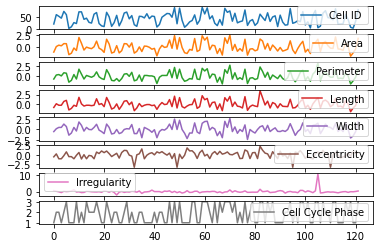

In [ ]:
ax = normalized_training.plot(subplots=True)

### Let's perform a Principal Component Analysis

#### start by separating our data in features and labels

In [ ]:
X = normalized_training.loc[:, mean_values.keys()].values #get only the features data that we had already stored as keys in mean_values
y = normalized_training.loc[:, "Cell Cycle Phase"].values

#### 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_X = pca.fit_transform(X)
pca_X.shape

(122, 3)

### Let's see how well PCA separates the data according to cell cycle phases

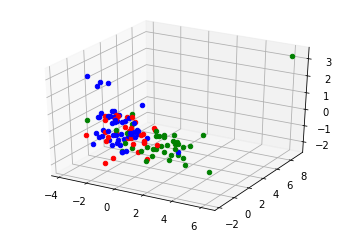

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(pca_X.shape[0]):
  if y[i] == 1:
    ax.scatter(pca_X[i][0], pca_X[i][1], pca_X[i][2], c="b")
  elif y[i] == 2:
    ax.scatter(pca_X[i][0], pca_X[i][1], pca_X[i][2], c="r")
  elif y[i] == 3:
    ax.scatter(pca_X[i][0], pca_X[i][1], pca_X[i][2], c="g")
plt.show()

### Combine PCA with K-Neighbours to automatically classify new data

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNC

knc = KNC(n_neighbors=5)
knc.fit(pca_X, y)

val_X = normalized_validation.loc[:, mean_values.keys()]

val_pca_X = pca.transform(val_X)

val_predictions = knc.predict(val_pca_X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### Calculate prediction accuracy

In [ ]:
val_y = normalized_validation.loc[:, "Cell Cycle Phase"].values

correct = 0
total = val_predictions.shape[0]
for i in range(total):
  if val_predictions[i] == val_y[i]:
    correct += 1

100 * correct / total

61.29032258064516

#### Quantify the cell cycle phases of the sle1 data

Load the datatable

In [ ]:
# Your code here

Normalize the values

In [ ]:
# Your code here

Project the values into the PCA space

In [ ]:
# Your code here

Classify them using the K-Neighbours classifier

In [ ]:
# Your code here

Measure the accuracy

In [ ]:
# Your code here

# Compare the cell cycle phase ratios of the groundtruth and the automatic classification

start by doing this for the wt data

In [ ]:
phases_count = {phase:data["Cell Cycle Phase"].tolist().count(phase) for phase in data["Cell Cycle Phase"].tolist()}
total = 0
for phase in phases_count:
  total += phases_count[phase]

phases_perc = {}
for phase in phases_count:
  phases_perc[phase] = phases_count[phase] / total

phases_perc

{3: 0.38202247191011235, 1: 0.34831460674157305, 2: 0.2696629213483146}

now for the sle1 data

PS: sle1 corresponds to deletion of a gene that causes an increase in Phase 3 cells

In [ ]:
# Your code here